## Assignment 3 : Implementation of methods for min-max optimization problems

This jupyter notebook is Assignment 3 for the course "EN.553.662: Optimization for Data Science".

In this assignment we will focus on the practical implementation of Gradient Methods for solving min-max optimization problems. All algorithms and their convergence guarantees presented in the class. 

You have to complete 4 tasks. The first task worth 40 points while the other three tasks (2,3 and 4) worth 20 points each. The assignment has 100 points in total.  

The Assignemnt is equivalent to 15% of the final grade. 

Please submit the ipynb file to CANVAS. Penalty for not doing so (submitting a pdf instead): 10 points. 
Penalty for delay submission (without a valid reason): 20 points.

The missing parts of the code which require your input (update in terms of code) are denoted with ............



## Problem Setup: ##

In this assignment we will focus on two classes of min-max opttimzation problems. That is, 
- (i) Stochastic quadratic strongly-convex storngly-concave 
- (ii) Stochastic bilinear min-max problem

Let us provide the details for each one of the above two classes of min-max problems:

#### (i) Stochastic quadratic strongly-convex storngly-concave:
\begin{equation}
  \min_{x_1 \in \mathbb{R}^{d}} \max_{x_2 \in \mathbb{R}^{d}} f(x_1,x_2) := \frac{1}{n}\sum_i \frac{1}{2} x_1^\top A_i x_1 + x_1^\top B_i x_2 - \frac{1}{2} x_2^\top C_i x_2 + a_i^\top x_1 - c_i^\top x_2
\end{equation}

In all our experiments, we choose $d = 100$ and $n=100$. To sample the matrices $A_i$ (resp. $C_i$) we first generate a random orthogonal matrix $Q_i$ (resp. $Q'_i$), we then sample a random diagonal matrix $D_i$ (resp. $D'_i$) where the elements on the diagonal are sampled uniformly in $[\mu_A, L_A]$ (resp. $[\mu_C, L_C]$), such that $\textbf{at least one of the matrices}$ has a minimum eigenvalue equal to $\mu_A$ (resp. $\mu_C$) and one matrix has a maximum eigenvalue equal to $L_A$ (resp. $L_C$).  Finally we construct the matrices by computing $A_i=Q_iD_iQ_i^\top$ (resp. $C_i = Q'_iD'_i{Q'}_i^\top$). This ensures that the matrices $A_i$ and $C_i$ for all $i \in [n]$, are symmetric and positive definite. We sample the matrices $B_i$ in a similar fashion with the diagonal matrix $D_i$ to lie between $[\mu_B, L_B]$. The bias terms $a_i, c_i$ are sampled from a $\mathcal{N}(0,1)$. 

In all our experiments, related to quadratic strongly-convex storngly-concave problems, we choose $\mu_A=\mu_C=0.1$, $L_A=L_C=1$, $\mu_B=0$ and $L_B=1$ unless stated otherwise. 


#### Remark on the computation of $\mu$ and $L$ :
After the generation of the min-max problem, define the operator $F(x_1, x_2) = \begin{pmatrix} \nabla_{x_1} f(x_1, x_2) &  -\nabla_{x_2} f(x_1, x_2) \end{pmatrix}^{\top}$. Then use the following two results to compute the strong monotonicity parameter $\mu$ and the lipschitz constant $L$ of operator $F$.

$\textbf{Result 1}$: If $f(x_1,x_2)$ is $\mu_1$-strongly convex $\mu_2$-strongly concave, then the operator $F$ is $\min\{ \mu_1, \mu_2\}$-strongly monotone.

$\textbf{Result 2}$: Given an operator of the form $F(x) = Mx + \varepsilon$ for some matrix $M \in \mathbb{R}^{d \times d}$ and $\varepsilon \in \mathbb{R}^d$, the lipschitz constant of $F$ is given by $\sqrt{\lambda_{\max}(M^{\intercal}M)}$. 

#### (i) Stochastic bilinear min-max problem:
\begin{equation}
 \min_{x_1 \in \mathbb{R}^{d}} \max_{x_2 \in \mathbb{R}^{d}} \frac{1}{n} \sum_{i=1}^n \left( x_1^\top b_i+x_1^\top A_i x_2 +c_i^\top x_2 \right) \end{equation}
 
For this problem we choose $n=d_1=d_2=100$, $[A_i]_{kl} = 1$ if $i = k = l$ and 0 otherwise, and $[b_i]_k, [c_i]_k \sim \mathcal{N}(0, 1/n)$.

### 2. Generate Data 

As a first pre-task, please write the code for generating the above two problems.  

In [572]:
import numpy as np

In [573]:
def generate_orthogonal_matrix(d):
    """Generate a random orthogonal matrix of size d x d."""
    H = np.random.randn(d, d)
    Q, _ = np.linalg.qr(H)
    return Q

def generate_strongly_convex_concave_data(n, d, mu_A, L_A, mu_C, L_C, mu_B, L_B):
    """Generate data for the stochastic quadratic strongly-convex strongly-concave problem."""
    A_matrices = []
    C_matrices = []
    B_matrices = []
    a_vectors = []
    c_vectors = []

    # Randomly select indices to set the min and max eigenvalues
    min_eigen_A_idx = np.random.randint(n)
    max_eigen_A_idx = np.random.randint(n)
    min_eigen_C_idx = np.random.randint(n)
    max_eigen_C_idx = np.random.randint(n)

    for i in range(n):
        # Generate orthogonal matrices
        Q_A = generate_orthogonal_matrix(d)
        Q_C = generate_orthogonal_matrix(d)

        # Generate diagonal matrices
        D_A = np.random.uniform(mu_A, L_A, d)
        D_C = np.random.uniform(mu_C, L_C, d)

        # Ensure eigenvalue constraints
        if i == min_eigen_A_idx:
            D_A[0] = mu_A
        if i == max_eigen_A_idx:
            D_A[0] = L_A
        if i == min_eigen_C_idx:
            D_C[0] = mu_C
        if i == max_eigen_C_idx:
            D_C[0] = L_C

        # Construct matrices
        A_matrices.append(Q_A @ np.diag(D_A) @ Q_A.T)
        C_matrices.append(Q_C @ np.diag(D_C) @ Q_C.T)
        B_matrices.append(np.diag(np.random.uniform(mu_B, L_B, d)))

        # Sample bias vectors a_i and c_i
        a_vectors.append(np.random.randn(d))
        c_vectors.append(np.random.randn(d))

    return A_matrices, C_matrices, B_matrices, a_vectors, c_vectors

# Parameters
n = 100
d = 100
mu_A = mu_C = 0.1
L_A = L_C = 1
mu_B = 0
L_B = 1

# Generate data
A_matrices, C_matrices, B_matrices, a_vectors, c_vectors = generate_strongly_convex_concave_data(n, d, mu_A, L_A, mu_C, L_C, mu_B, L_B)

In [574]:
# we need to implemenmt a function which compute the mu, as it will be needed for later to determine the step-size 
def compute_mu(A_matrices, C_matrices, n):
    """Compute the strong monotonicity parameter mu for the SCSC problem."""
    # Calculate the average of A_matrices and C_matrices
    A_avg = sum(A_matrices) / n
    C_avg = sum(C_matrices) / n

    # Compute the smallest eigenvalues of A_avg and C_avg
    mu1 = np.min(np.linalg.eigvalsh(A_avg))
    mu2 = np.min(np.linalg.eigvalsh(C_avg))

    # The final mu is the smaller of mu1 and mu2
    mu = min(mu1, mu2)

    return mu

# Example Usage:
# Assuming A_matrices and C_matrices are generated using the data generator
mu = compute_mu(A_matrices, C_matrices, n)
mu

0.5014063426937307

In [575]:
# compute the L for SCSC
def compute_L(A_matrices, B_matrices, C_matrices, n):
    """Compute the Lipschitz constant L for the SCSC problem."""
    # Calculate the average of A_matrices, B_matrices, and C_matrices
    A_avg = sum(A_matrices) / n
    B_avg = sum(B_matrices) / n
    C_avg = sum(C_matrices) / n

    # Form the matrix M
    M = np.block([[A_avg, B_avg], [-B_avg.T, C_avg]])

    # Compute the Lipschitz constant L
    L = np.sqrt(np.max(np.linalg.eigvalsh(M.T @ M)))

    return L

# Example Usage:
L = compute_L(A_matrices, B_matrices, C_matrices, n)
L

0.8198691945971572

In [576]:
## Bilinear Problem (generate the problem)
def generate_corrected_bilinear_data(n, d):
    """
    Generate data for the stochastic bilinear min-max problem with the corrected matrix A_i construction.
    """
    A_matrices = []
    b_vectors = []
    c_vectors = []

    for i in range(n):
        # Generate matrix A_i with only one entry (i % d, i % d) set to 1
        A_i = np.zeros((d, d))
        A_i[i % d, i % d] = 1
        A_matrices.append(A_i)

        # Generate vectors b_i and c_i
        b_vectors.append(np.random.normal(0, 1/n, d))
        c_vectors.append(np.random.normal(0, 1/n, d))

    return A_matrices, b_vectors, c_vectors

# Regenerate the data with the corrected approach
corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors = generate_corrected_bilinear_data(n, d)

In [577]:
# compute the L for the bilinear setting 
def compute_L_bilinear(A_matrices, n):
    """Compute the Lipschitz constant L for the bilinear min-max problem."""
    # Calculate the average of A_matrices
    A_avg = sum(A_matrices) / n

    # Form the matrix M
    M = np.block([[np.zeros(A_avg.shape), A_avg], [A_avg.T, np.zeros(A_avg.shape)]])

    # Compute the Lipschitz constant L
    L = np.sqrt(np.max(np.linalg.eigvalsh(M.T @ M)))

    return L

# Example Usage:
# Assuming A_matrices are generated using the data generator
L_bi = compute_L_bilinear(corrected_A_matrices_bilinear, n)
L_bi

0.01

In [578]:
## before we proceed to the next part of the assignment, we need to generate X* for the ground truth, 
## which will be used to evalutae our performance of our algorithm later 

def solve_quadratic_problem(A_matrices, C_matrices, B_matrices, a_vectors, c_vectors, n):
    """Solve the stochastic quadratic strongly-convex strongly-concave problem."""
    # Calculate the average matrices and vectors
    A_sum = sum(A_matrices) / n
    C_sum = sum(C_matrices) / n
    B_sum = sum(B_matrices) / n
    a_sum = sum(a_vectors) / n
    c_sum = sum(c_vectors) / n

    # Solving the linear system
    # 0 = A_sum * x1 + B_sum * x2 + a_sum
    # 0 = -B_sum.T * x1 - C_sum * x2 - c_sum
    matrix = np.block([[A_sum, B_sum], [B_sum.T, -C_sum]])
    vector = np.block([-a_sum, c_sum])
    solution = np.linalg.solve(matrix, vector)
    
    x1_star, x2_star = solution[:len(solution)//2], solution[len(solution)//2:]
    return x1_star, x2_star

# Example Usage:
# Assuming A_matrices, C_matrices, B_matrices, a_vectors, c_vectors are generated using the data generator
x1_star, x2_star = solve_quadratic_problem(A_matrices, C_matrices, B_matrices, a_vectors, c_vectors, n)

In [579]:
x1_star, x2_star

(array([-0.05685353, -0.06930257, -0.24309618, -0.1089924 ,  0.18781515,
         0.05453726, -0.17570637,  0.0917587 ,  0.05563059,  0.12744923,
         0.07594801,  0.02083519, -0.07667517, -0.11110332, -0.06975785,
         0.20202068,  0.1189706 , -0.12800166,  0.05366205,  0.15544134,
        -0.04839348, -0.10483749, -0.16503648,  0.19452154,  0.21109541,
        -0.22621914,  0.02309326, -0.1486849 , -0.13354318,  0.00871513,
         0.05069938,  0.03531574,  0.07466324, -0.03848704, -0.11290959,
        -0.00447621,  0.16124381,  0.07893243, -0.04196106, -0.04203731,
        -0.05922676, -0.08048319, -0.1044962 ,  0.24773094,  0.05664831,
        -0.04363858, -0.07800857, -0.25194648,  0.16452713, -0.01782994,
         0.08910311, -0.09077643,  0.25690298, -0.08719508,  0.13027027,
         0.02117312, -0.20394506, -0.02489171, -0.15935745, -0.04410393,
         0.02912735, -0.00642234, -0.06788235,  0.20154281, -0.11751014,
        -0.04063353, -0.04097189,  0.03988692,  0.0

In [580]:
## Let us do the same for bilinear problem! 
def solve_bilinear_problem(A_matrices, b_vectors, c_vectors, n):
    """Solve the stochastic bilinear min-max problem."""
    # Calculate the average matrices and vectors
    A_sum = sum(A_matrices) / n
    b_sum = sum(b_vectors) / n
    c_sum = sum(c_vectors) / n

    # Solving the linear system
    # 0 = b_sum + A_sum * x2
    # 0 = A_sum.T * x1 + c_sum
    matrix = np.block([[np.zeros(A_sum.shape), A_sum], [A_sum.T, np.zeros(A_sum.shape)]])
    vector = -np.block([b_sum, c_sum])
    solution = np.linalg.solve(matrix, vector)
    
    x1_star, x2_star = solution[:len(solution)//2], solution[len(solution)//2:]
    return x1_star, x2_star

# Example Usage:
# Assuming A_matrices, b_vectors, c_vectors are generated using the data generator
x1_star_bi, x2_star_bi = solve_bilinear_problem(corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors,n)
x1_star_bi,x2_star_bi

(array([ 0.09387996,  0.01875664, -0.04213322, -0.03976975,  0.15854186,
         0.01055927, -0.05010885,  0.05854502, -0.05958865,  0.15004462,
        -0.04930307, -0.12094663,  0.10479876,  0.10096505,  0.03664222,
         0.06201412, -0.17346793,  0.00297634, -0.00684182, -0.03556219,
         0.18527914, -0.01665714, -0.08221864, -0.06767131,  0.10179255,
        -0.02275064, -0.03188748,  0.02243299, -0.00296216,  0.13852693,
         0.03195457, -0.08566438,  0.0854627 , -0.06286978,  0.08182462,
        -0.031567  , -0.04398142,  0.05513794, -0.06090236, -0.00390955,
         0.08645969,  0.03767057,  0.06669801,  0.03290474, -0.12021079,
         0.06970438,  0.06556201, -0.00169758, -0.05337332,  0.00332989,
        -0.06436206,  0.01201089, -0.17288333, -0.00871756,  0.18283369,
        -0.10260743, -0.1300685 , -0.06032204,  0.05752993, -0.05177497,
        -0.07279159,  0.0063732 , -0.02489316, -0.05180693, -0.08288874,
        -0.08365211,  0.03403199, -0.08124145, -0.1

## Summary for my preperation stage

In this section, I developed a comprehensive suite of functions tailored to address two specific types of optimization problems: the Stochastic Quadratic Strongly-Convex Strongly-Concave (SCSC) problem and the Stochastic Bilinear Min-Max problem. The key components of this suite include:

1. **Synthetic Data Generation**: We implemented two functions dedicated to generating synthetic data. Each function is uniquely designed for one of the two problem types, ensuring that the data is appropriately structured and adheres to the specific requirements of each problem.

2. **Lipschitz Constant Computation (L)**: Two separate functions were created to calculate the Lipschitz constant $ L $. One function is for the SCSC problem, and the other is for the bilinear problem. These functions are crucial for analyzing the convergence properties and stability of optimization algorithms applied to these problems.

3. **Strong Monotonicity Parameter Computation (mu)**: For the SCSC problem, a specific function was designed to compute the strong monotonicity parameter $ \mu $. This parameter plays a vital role in understanding the optimization landscape and the robustness of solutions.

4. **Ground Truth Computation**: Lastly, two additional functions were written to compute the ground truth solutions for both the SCSC and bilinear problems. These functions solve the optimization problems numerically, providing a benchmark against which the performance of optimization algorithms can be measured.

Together, these functions form a robust toolkit for analyzing and solving the SCSC and bilinear optimization problems, allowing for a thorough exploration and understanding of these complex mathematical challenges.

### Task 1: Numerical Evaluation of Deterministic Methods

In this first task we verify the numerical beheviour of the deterministic methods covered in the class for the two problems under study: (i)  quadratic SC-SC  and (ii) bilinear min-max problem. 

In particular we run the following algorithms for each problem:
1. Determninistic gradient descent-ascent (GDA) for solving quadratic SC-SC
$$ x^{k+1} =  x^k- \gamma F(x^k)$$
2. Deterministic Extragradient methods (EG) for solving the quadratic SC-SC and the bilinear problem
$$ x^{k+1} =  x^k- \gamma F(x^k- \gamma F(x^k))$$
3. The Deterministic Hamiltonian Method (HGD) for solving the bilinear problem
$$ x^{k+1} =  x^k- \gamma J^\top(x^k) F(x^k)$$

Since we are in the deterministic regime then all methods should be run with constant step-sizes. Please use the constant step-size selection provided in the class for the above algorithms to solve the following tasks. For all plots in this task, to evaluate the methods use the relative error measure  $\frac{\|x^k - x^* \|^2}{\|x^0 - x^* \|^2}$ and plot its value as the algorithm progress. 

$\textbf{1.1.}$ (8 points) Design constant step-size GDA. What value of the step-size you can use to guarantee convergence (provide explanation)? How do you expect the method to behave (based on our theoretical results) for quadratic SC-SC and how for bilinear games? 

$\textbf{1.2.}$ (8 points) Design constant step-size EG. What value of the step-size you can use to guarantee convergence (provide explanation)? How do you expect the method to behave (based on our theoretical results) for quadratic SC-SC and how for bilinear games? 

$\textbf{1.3.}$ (8 points) Design constant step-size HGD? What value of the step-size you can use to guarantee convergence (provide explanation)? How do you expect the method to behave (based on our theoretical results) for quadratic SC-SC and how for bilinear games? 

In [189]:
import matplotlib.pyplot as plt
def plot_line_chart(data, title='Line Chart', xlabel='X-axis', ylabel='Y-axis'):
    """
    Plots a line chart for the given data.

    :param data: List of values to plot.
    :param title: Title of the chart (default is 'Line Chart').
    :param xlabel: Label for the X-axis (default is 'X-axis').
    :param ylabel: Label for the Y-axis (default is 'Y-axis').
    """
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(data, marker='o')  # Plot the data with circle markers
    plt.title(title)  # Set the title of the plot
    plt.xlabel(xlabel)  # Set the x-axis label
    plt.ylabel(ylabel)  # Set the y-axis label
    plt.grid(True)  # Enable grid for better readability
    plt.show()

In [142]:
gama_GDA=1/(2*L) #  constant step-size for GDA// given in the lecture. 
gama_GDA

0.6224264237425875

In [306]:
def GDA_min_max_with_error(data, problem_type, gamma, num_iterations, x1_star, x2_star):
    """
    Gradient Descent-Ascent (GDA) algorithm for quadratic SC-SC and bilinear min-max problems,
    handling separate variables x1 and x2, and computing the relative error rate.

    :param data: Synthetic data for the problem (matrices and vectors).
    :param problem_type: Type of the problem ('quadratic_SCSC' or 'bilinear').
    :param gamma: Step size.
    :param num_iterations: Number of iterations to run the algorithm.
    :param x1_star: Optimal point for x1.
    :param x2_star: Optimal point for x2.
    :return: List of relative errors over the iterations.
    """
    if problem_type == 'quadratic_SCSC':
        A_matrices, C_matrices, B_matrices, a_vectors, c_vectors = data
        grad_x1 = lambda x1, x2: np.mean([A_matrices[i] @ x1 + B_matrices[i] @ x2 + a_vectors[i] for i in range(len(A_matrices))], axis=0)
        grad_x2 = lambda x1, x2: np.mean([B_matrices[i].T @ x1 - C_matrices[i] @ x2 - c_vectors[i] for i in range(len(C_matrices))], axis=0)
    elif problem_type == 'bilinear':
        A_matrices, b_vectors, c_vectors = data
        grad_x1 = lambda x1, x2: np.mean([b_vectors[i] + A_matrices[i] @ x2 for i in range(len(A_matrices))], axis=0)
        grad_x2 = lambda x1, x2: np.mean([c_vectors[i] + A_matrices[i].T @ x1 for i in range(len(A_matrices))], axis=0)
    else:
        raise ValueError("Invalid problem type. Choose 'quadratic_SCSC' or 'bilinear'.")

    x1 = np.zeros(len(data[0][0]))  # Assuming initial point x1 is the origin
    x2 = np.zeros_like(x1)         # Assuming initial point x2 is the origin
    relative_errors = []

    for _ in range(num_iterations):
        x1 = x1 - gamma * grad_x1(x1, x2)
        x2 = x2 + gamma * grad_x2(x1, x2)
        error_x1 = np.linalg.norm(x1 - x1_star)**2
        error_x2 = np.linalg.norm(x2 - x2_star)**2
        relative_error_1 = (error_x1 ) / (np.linalg.norm(x1_star)**2)
        relative_error_2=(error_x2)/(np.linalg.norm(x2_star)**2)
        relative_error=(relative_error_1+relative_error_2)/2
        relative_errors.append(relative_error)

    return relative_errors

In [197]:
error=GDA_min_max_with_error((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors), 'quadratic_SCSC', gama_GDA, 100,x1_star, x2_star)

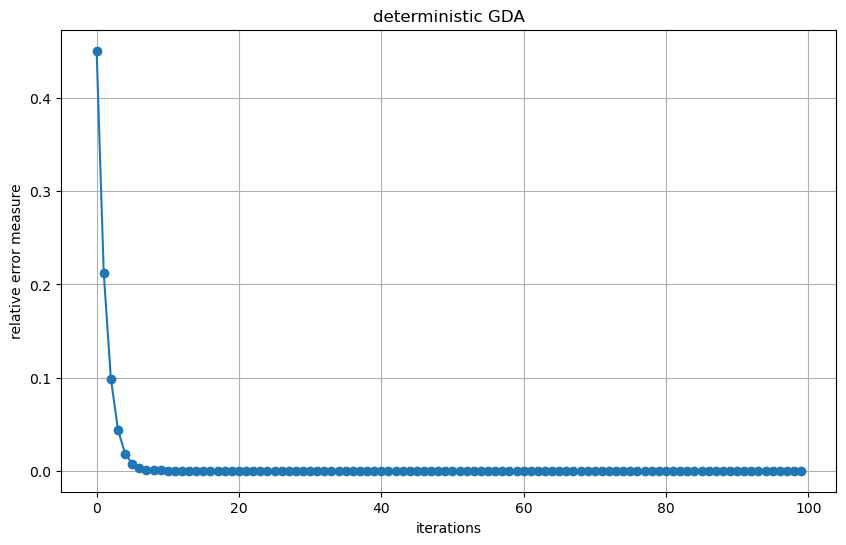

In [198]:
# you can see fast convergence with a step-size calculated in 1/(2L) "this way was specified in lecture slide". 
plot_line_chart(error, title='deterministic GDA', xlabel='iterations', ylabel='relative error measure')

In [298]:
def extragradient_method_with_error(data, problem_type, gamma, num_iterations, x1_star, x2_star):
    """
    Extragradient (EG) method for quadratic SC-SC and bilinear min-max problems,
    handling separate variables x1 and x2, and computing the relative error rate.

    :param data: Synthetic data for the problem (matrices and vectors).
    :param problem_type: Type of the problem ('quadratic_SCSC' or 'bilinear').
    :param gamma: Step size.
    :param num_iterations: Number of iterations to run the algorithm.
    :param x1_star: Optimal point for x1.
    :param x2_star: Optimal point for x2.
    :return: List of relative errors over the iterations.
    """
    if problem_type == 'quadratic_SCSC':
        A_matrices, C_matrices, B_matrices, a_vectors, c_vectors = data
        grad_x1 = lambda x1, x2: np.mean([A_matrices[i] @ x1 + B_matrices[i] @ x2 + a_vectors[i] for i in range(len(A_matrices))], axis=0)
        grad_x2 = lambda x1, x2: np.mean([B_matrices[i].T @ x1 - C_matrices[i] @ x2 - c_vectors[i] for i in range(len(C_matrices))], axis=0)
    elif problem_type == 'bilinear':
        A_matrices, b_vectors, c_vectors = data
        grad_x1 = lambda x1, x2: np.mean([b_vectors[i] + A_matrices[i] @ x2 for i in range(len(A_matrices))], axis=0)
        grad_x2 = lambda x1, x2: np.mean([c_vectors[i] + A_matrices[i].T @ x1 for i in range(len(A_matrices))], axis=0)
    else:
        raise ValueError("Invalid problem type. Choose 'quadratic_SCSC' or 'bilinear'.")

    x1 = np.zeros(len(data[0][0]))  # Assuming initial point x1 is the origin
    x2 = np.zeros_like(x1)         # Assuming initial point x2 is the origin
    relative_errors = []

    for _ in range(num_iterations):
        # Extrapolation step
        tilde_x1 = x1 - gamma * grad_x1(x1, x2)
        tilde_x2 = x2 + gamma * grad_x2(x1, x2)

        # Actual update step
        x1 = x1 - gamma * grad_x1(tilde_x1, tilde_x2)
        x2 = x2 + gamma * grad_x2(tilde_x1, tilde_x2)

        error_x1 = np.linalg.norm(x1 - x1_star)**2
        error_x2 = np.linalg.norm(x2 - x2_star)**2
        
        relative_error_1 = (error_x1 ) / (np.linalg.norm(x1_star)**2)
        relative_error_2=(error_x2)/(np.linalg.norm(x2_star)**2)
        relative_error=(relative_error_1+relative_error_2)/2
        relative_errors.append(relative_error)

    return relative_errors

In [200]:
gama_EG=1/(8*L) #  constant step-size for EG// given in the lecture. 
gama_EG

0.15560660593564687

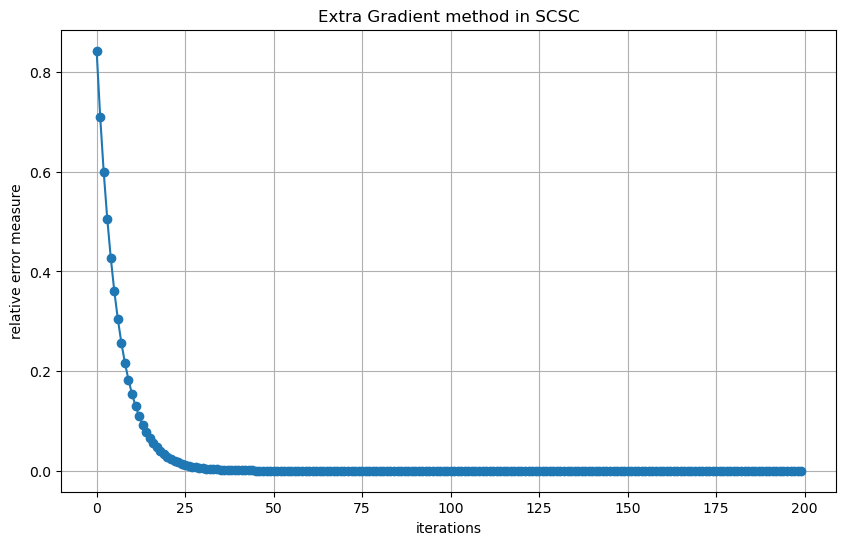

In [209]:
# run the experimet for SCSC
error_EG=extragradient_method_with_error((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors), 'quadratic_SCSC', gama_EG, 200,x1_star, x2_star)
plot_line_chart(error_EG, title='Extra Gradient method in SCSC', xlabel='iterations', ylabel='relative error measure')

In [204]:
# before running the simulation of bilinear game, we should compute the right step-size:
def compute_step_size_extragradient(A_matrices):
    """
    Compute the step size for the extragradient method in the bilinear game,
    considering the sum of A_i matrices.

    Parameters:
    A_matrices (list of numpy.ndarray): List of matrix A_i in the bilinear setting.

    Returns:
    float: The step size gamma for the extragradient method.
    """
    # Sum the A matrices
    A_sum = np.mean(A_matrices, axis=0)

    # Calculate the maximum eigenvalue of the sum of A^T A
    lambda_max = np.max(np.linalg.eigvals(np.dot(A_sum.T, A_sum)))

    # Compute the step size using the provided formula
    gamma = 1 / (2 * np.sqrt(2 * lambda_max))
    return gamma

# Example usage:
gamma_extragradient = compute_step_size_extragradient(corrected_A_matrices_bilinear)
gamma_extragradient

35.35533905932738

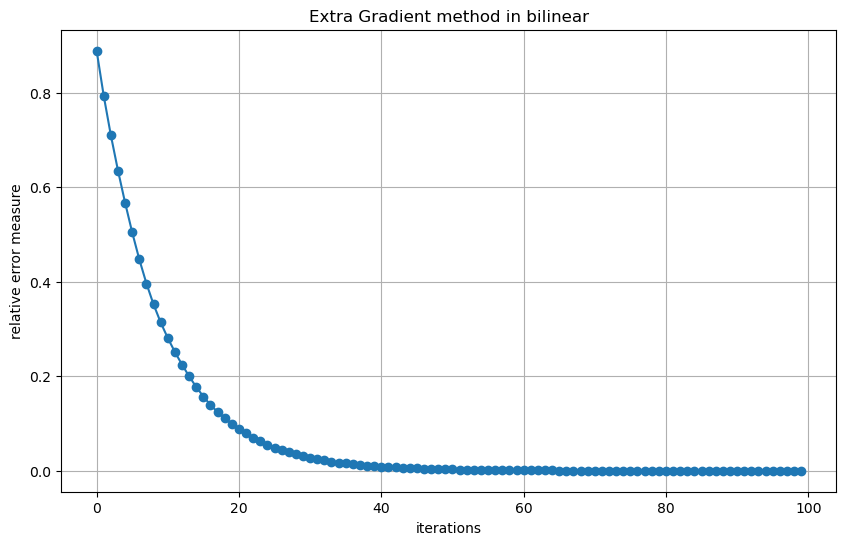

In [210]:
# run the experiment for bilinear game
error_EG_bi=extragradient_method_with_error((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors),'bilinear', gamma_extragradient, 100,x1_star_bi,x2_star_bi)
plot_line_chart(error_EG_bi, title='Extra Gradient method in bilinear', xlabel='iterations', ylabel='relative error measure')

In [726]:
def HGD_bilinear(data, gamma, num_iterations, x1_star, x2_star):
    """
    Hamiltonian Gradient Descent (HGD) algorithm for bilinear min-max problems using the Hessian matrix.

    :param data: Synthetic data for the problem (matrices A, b, c).
    :param gamma: Step size.
    :param num_iterations: Number of iterations to run the algorithm.
    :param x1_star: Optimal point for x1.
    :param x2_star: Optimal point for x2.
    :return: List of relative errors over the iterations.
    """
    A_matrices, b_vectors, c_vectors = data

    x1 = np.zeros(len(A_matrices[0]))  # Initial point x1
    x2 = np.zeros_like(x1)             # Initial point x2
    relative_errors = []

    for _ in range(num_iterations):
        
        # compute the gradient first
        grad_x1 = np.mean([A @ x2 + b for A, b in zip(A_matrices, b_vectors)], axis=0)
        grad_x2 = -np.mean([A.T @ x1 + c for A, c in zip(A_matrices, c_vectors)], axis=0)
        
        # compute each entry in our Hessian (matrix J)
        term_1=np.zeros_like(A_matrices[0]) #row1 
        term_2=np.mean(A_matrices,axis=0) #row1
        
        term_3=np.mean(A_matrices,axis=0).T
        term_4=np.zeros_like(A_matrices[0])
        
        x_1_update=term_1@grad_x1-term_3@grad_x2
        x_2_update=term_2@grad_x1-term_4@grad_x2
        
        x1=x1-gamma*x_1_update
        x2=x2-gamma*x_2_update


        # Calculate the relative error
        error_x1 = np.linalg.norm(x1 - x1_star)**2
        error_x2 = np.linalg.norm(x2 - x2_star)**2
        relative_error_1 = error_x1 / np.linalg.norm(x1_star)**2
        relative_error_2 = error_x2 / np.linalg.norm(x2_star)**2
        relative_error = (relative_error_1 + relative_error_2) / 2
        relative_errors.append(relative_error)

    return relative_errors

In [258]:
# gama for HGD
gama_HGD=1/(2*L_bi)
gama_HGD

50.0

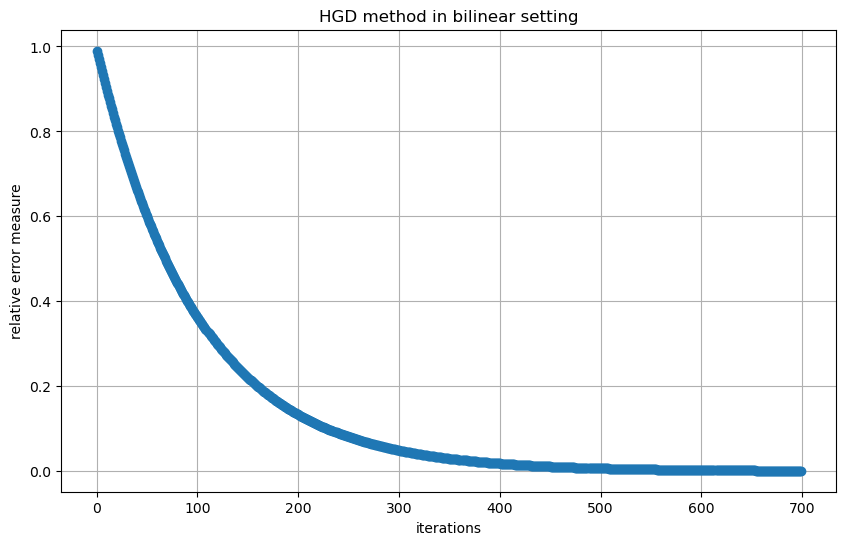

In [727]:
error_HGD=HGD_bilinear((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors), gama_HGD, 700,x1_star_bi,x2_star_bi)
plot_line_chart(error_HGD, title='HGD method in bilinear setting', xlabel='iterations', ylabel='relative error measure')

## Summary for this section

In this section, I designed three different learning algorithms that helps solve the min-max optimization. 
In addition to design these algorithms, I also run these algorithms and plot the relative error rates to prove to you that they do work well in all setting.
### 1.1. Deterministic Gradient Descent-Ascent (GDA)

#### Step-Size Design:
For GDA, the step-size $(\gamma)$ needs to be chosen such that it guarantees convergence.From the lecture we know that the step-size alpha should be $1/2l_{SCSC}$. For bilinear problem, the GDA will never converge to the actual solution regardless of the choice of step-size.

#### Expected Behavior:
- **Quadratic SC-SC**: GDA should exhibit a convergent behavior due to the strong convexity-concavity of the problem. The convergence rate will be steady but may be slow if the condition number is large.
- **Bilinear Games**: For bilinear problems, GDA might oscillate or even diverge because the objective function does not satisfy the strong convexity-concavity condition. This problem lacks a natural notion of "balance" in the gradient steps, leading to potential instability.

### 1.2. Deterministic Extragradient (EG)

#### Step-Size Design:
EG method here are suitable for both bilinear problem and SCSC problem. In the context of bilinear setting, the step-size should be set to $1/(2*(2 \lambda_{max}(A^TA)^{1/2})$. The right step-size for SCSC problem should be $1/(8L_{SCSC})$

#### Expected Behavior:
- **Quadratic SC-SC**: EG is expected to perform well and converge reliably due to the extra gradient step providing a more accurate direction for the update. This method can mitigate some of the issues arising from the condition number of the problem.
- **Bilinear Games**: EG has a better chance of converging in bilinear settings compared to GDA, as the extra gradient step adds stability. However, convergence is not guaranteed since bilinear problems inherently lack strong convexity-concavity.

### 1.3. Deterministic Hamiltonian Method (HGD)

#### Step-Size Design:
The HGD is not suitable for SCSC problem. For the bilinear setting, we should expect the learning rate to be $1/(2L_{bilinear})$ in order to have expected convergence. 

#### Expected Behavior:
- **Quadratic SC-SC**: HGD is not typically used for quadratic SC-SC problems, as its design is more suited for problems where the gradient dynamics can be represented as a Hamiltonian system (like bilinear games).
- **Bilinear Games**: HGD should perform well in bilinear settings, as it leverages the structure of the problem. It can potentially offer faster convergence and better stability compared to GDA and EG, especially in problems where the Hamiltonian representation aligns well with the problem's dynamics.

In all cases, the relative error measure $\frac{\|x^k - x^* \|^2}{\|x^0 - x^* \|^2}$ will be a critical metric for evaluating the convergence and efficiency of these algorithms. The choice of step-size and the consequent behavior of these methods must be empirically validated through numerical experiments, considering the theoretical underpinnings discussed.

$\textbf{1.4.}$ (4 points) Compare GDA and EG for solving the quadratic SC-SC. Explain what step-sizes you select for each method and why.  Explain your findings. 

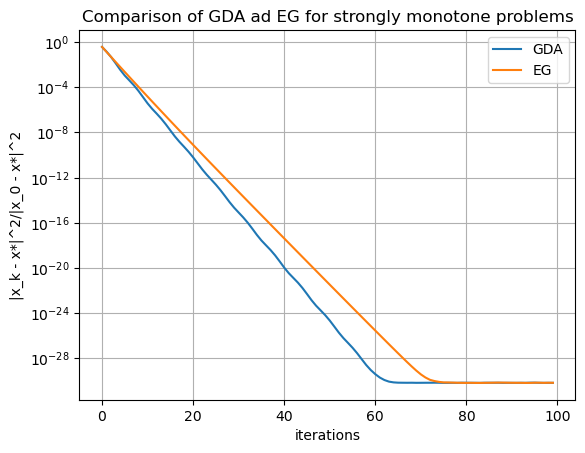

In [300]:
# Compare GDA and EG for problems under study
# experiment 1
gamma_1=0.0009
GDA_err =GDA_min_max_with_error((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors), 'quadratic_SCSC', 0.8, 100,x1_star, x2_star)
EG_err = extragradient_method_with_error((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors), 'quadratic_SCSC', 0.8, 100,x1_star, x2_star)

plt.plot(np.arange(len(GDA_err)), GDA_err, label = 'GDA')
plt.plot(np.arange(len(EG_err)), EG_err, label = 'EG')

plt.yscale('log')
plt.grid(True)
plt.ylabel("|x_k - x*|^2/|x_0 - x*|^2")
plt.xlabel("iterations")
plt.legend()
plt.title('Comparison of GDA ad EG for strongly monotone problems (learning rate of 0.8)')
plt.show()

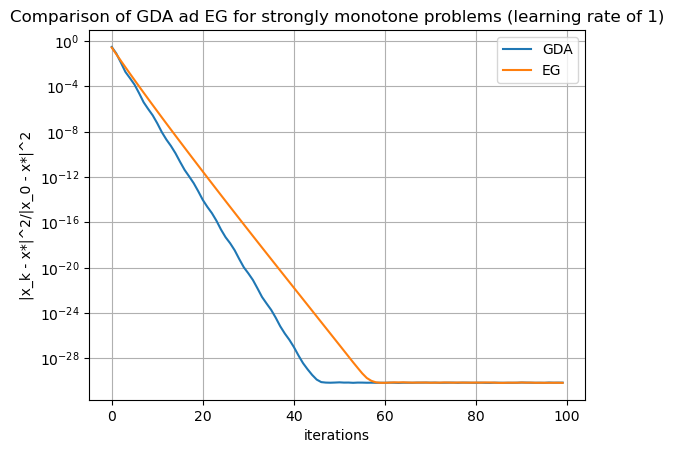

In [303]:
# Compare GDA and EG for problems under study
# experiment 2
GDA_err =GDA_min_max_with_error((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors), 'quadratic_SCSC', 1, 100,x1_star, x2_star)
EG_err = extragradient_method_with_error((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors), 'quadratic_SCSC', 1, 100,x1_star, x2_star)

plt.plot(np.arange(len(GDA_err)), GDA_err, label = 'GDA')
plt.plot(np.arange(len(EG_err)), EG_err, label = 'EG')

plt.yscale('log')
plt.grid(True)
plt.ylabel("|x_k - x*|^2/|x_0 - x*|^2")
plt.xlabel("iterations")
plt.legend()
plt.title('Comparison of GDA ad EG for strongly monotone problems (learning rate of 1)')
plt.show()

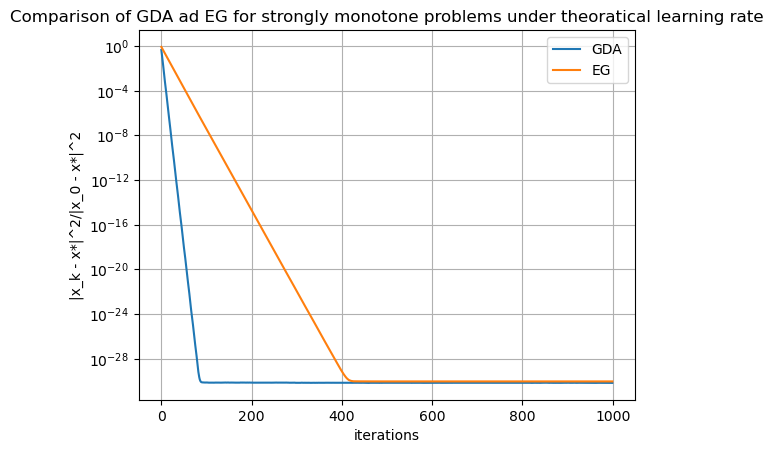

In [302]:
# Compare GDA and EG for problems under study
# experiment 3
GDA_err =GDA_min_max_with_error((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors), 'quadratic_SCSC', gama_GDA, 1000,x1_star, x2_star)
EG_err = extragradient_method_with_error((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors), 'quadratic_SCSC', gama_EG, 1000,x1_star, x2_star)

plt.plot(np.arange(len(GDA_err)), GDA_err, label = 'GDA')
plt.plot(np.arange(len(EG_err)), EG_err, label = 'EG')

plt.yscale('log')
plt.grid(True)
plt.ylabel("|x_k - x*|^2/|x_0 - x*|^2")
plt.xlabel("iterations")
plt.legend()
plt.title('Comparison of GDA ad EG for strongly monotone problems under theoratical learning rate')
plt.show()

## Summary of findings (1.4)

In this experiment, EG and GDA are compared in different step-sizes. 

By using the learning rate which was theoratical guranteed, while both GDA and EG can converge to the ground truth, GDA converges at much faster rate than EG does. 

If we use the same learning rate, GDA is still faster than EG, as shown in experiment 3. 

Overall, we can see that GDA should be preffered to EG as it converges faster. 

$\textbf{1.5.}$ (4 points) Compare GDA, EG, and HGD for solving the the given bilinear problem.  Explain what step-sizes you select for each method and why. Explain your findings. 

Text(0.5, 1.0, 'Comparison of GDA, EG and HGD for bilinear problems (EG and HGD are using theoratical learning rate)')

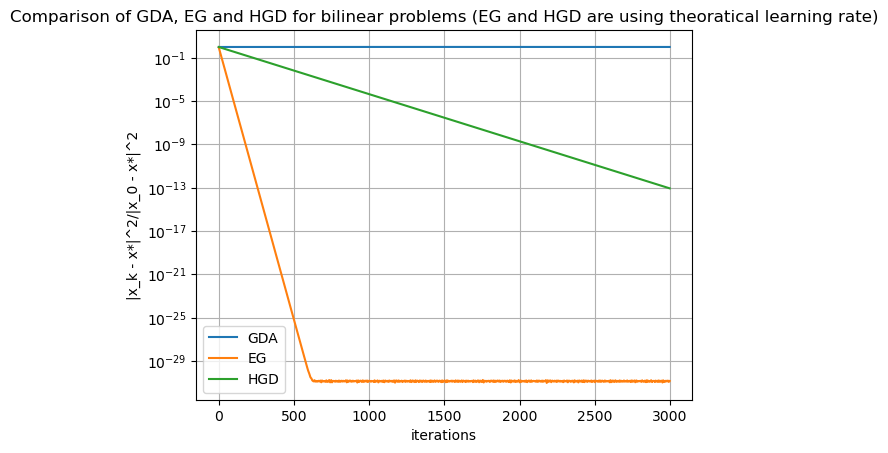

In [315]:
# Compare the methods for problems under study\
# Experiment 1
GDA_err=GDA_min_max_with_error((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors),'bilinear', 0.1, 3000,x1_star_bi,x2_star_bi)
EG_err = extragradient_method_with_error((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors),'bilinear', gamma_extragradient, 3000,x1_star_bi,x2_star_bi)
HGD_err = HGD_bilinear((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors), gama_HGD, 3000,x1_star_bi,x2_star_bi)

plt.plot(np.arange(len(GDA_err)), GDA_err, label = 'GDA')
plt.plot(np.arange(len(EG_err)), EG_err, label = 'EG')
plt.plot(np.arange(len(HGD_err)), HGD_err, label = 'HGD')

plt.yscale('log')
plt.grid(True)
plt.ylabel("|x_k - x*|^2/|x_0 - x*|^2")
plt.xlabel("iterations")
plt.legend()
plt.title('Comparison of GDA, EG and HGD for bilinear problems (EG and HGD are using theoratical learning rate)')

Text(0.5, 1.0, 'Comparison of GDA, EG and HGD for bilinear problems (under the learning rate of 40)')

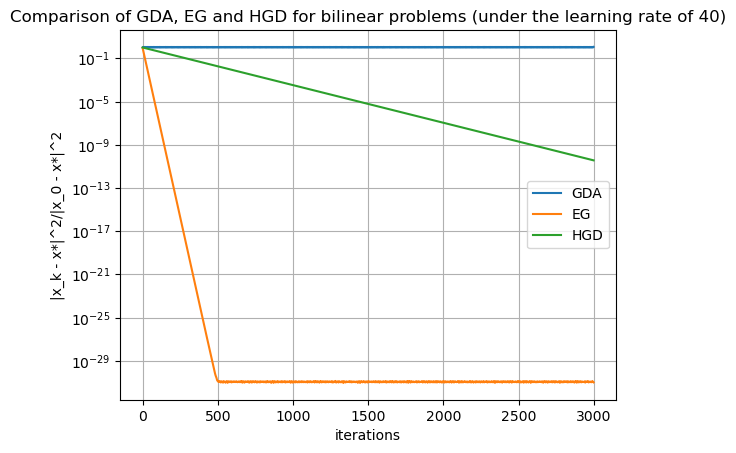

In [314]:
# Compare the methods for problems under study\
# Experiment 2
GDA_err=GDA_min_max_with_error((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors),'bilinear', 40, 3000,x1_star_bi,x2_star_bi)
EG_err = extragradient_method_with_error((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors),'bilinear', 40, 3000,x1_star_bi,x2_star_bi)
HGD_err = HGD_bilinear((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors), 40, 3000,x1_star_bi,x2_star_bi)

plt.plot(np.arange(len(GDA_err)), GDA_err, label = 'GDA')
plt.plot(np.arange(len(EG_err)), EG_err, label = 'EG')
plt.plot(np.arange(len(HGD_err)), HGD_err, label = 'HGD')

plt.yscale('log')
plt.grid(True)
plt.ylabel("|x_k - x*|^2/|x_0 - x*|^2")
plt.xlabel("iterations")
plt.legend()
plt.title('Comparison of GDA, EG and HGD for bilinear problems (under the learning rate of 40)')

## Summary of findings (1.5)

Indeed we can see Both HGD and EG converge to the acutal solution. GDA, on the other hand, does not converge, which is expected.

From both expertiments, we can also see that EG is faster than HGD in both experiment, under the learning rate we are using. 



$\textbf{1.6.}$ (8 points) Let us focus on the bilinear problems. For only this sub-task let us modify the bilinear problem to be a 2-dimension problem (by generating the bilinear problem following the decription of the previous sub-task but now for a 2-dimension problem). That is, we have $x_1 \in R$ and $x_2 \in R$ to be scalars. 

Run the GDA, EG and HGD to this 2-dimension bilinear problem and plot the trajectories on the vector space (here the vertical and horizontal axes represent the values of $x_1$ and $x_2$ respectively). Do the methods behave as the theory predicts? please explain. 

In [316]:
# generate new data
corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors = generate_corrected_bilinear_data(n, 2)

In [331]:
# get the optimal; (ground truth)
x1_star_bi, x2_star_bi = solve_bilinear_problem(corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors,2)
x1_star_bi,x2_star_bi

(array([0.00047928, 0.0010683 ]), array([-0.00155821, -0.00117742]))

In [324]:
# we need to modify our previous functions a little bit so that it spits out trajectories rather than relative errors.
def GDA_min_max(data, problem_type, gamma, num_iterations):
    """
    Gradient Descent-Ascent (GDA) algorithm for quadratic SC-SC and bilinear min-max problems,
    handling separate variables x1 and x2, and computing the relative error rate.

    :param data: Synthetic data for the problem (matrices and vectors).
    :param problem_type: Type of the problem ('quadratic_SCSC' or 'bilinear').
    :param gamma: Step size.
    :param num_iterations: Number of iterations to run the algorithm.
    :param x1_star: Optimal point for x1.
    :param x2_star: Optimal point for x2.
    :return: List of relative errors over the iterations.
    """
    if problem_type == 'quadratic_SCSC':
        A_matrices, C_matrices, B_matrices, a_vectors, c_vectors = data
        grad_x1 = lambda x1, x2: np.mean([A_matrices[i] @ x1 + B_matrices[i] @ x2 + a_vectors[i] for i in range(len(A_matrices))], axis=0)
        grad_x2 = lambda x1, x2: np.mean([B_matrices[i].T @ x1 - C_matrices[i] @ x2 - c_vectors[i] for i in range(len(C_matrices))], axis=0)
    elif problem_type == 'bilinear':
        A_matrices, b_vectors, c_vectors = data
        grad_x1 = lambda x1, x2: np.mean([b_vectors[i] + A_matrices[i] @ x2 for i in range(len(A_matrices))], axis=0)
        grad_x2 = lambda x1, x2: np.mean([c_vectors[i] + A_matrices[i].T @ x1 for i in range(len(A_matrices))], axis=0)
    else:
        raise ValueError("Invalid problem type. Choose 'quadratic_SCSC' or 'bilinear'.")

    x1 = np.zeros(len(data[0][0]))  # Assuming initial point x1 is the origin
    x2 = np.zeros_like(x1)         # Assuming initial point x2 is the origin

    x1_tra=[]
    x2_tra=[]
    for _ in range(num_iterations):
        x1 = x1 - gamma * grad_x1(x1, x2)
        x2 = x2 + gamma * grad_x2(x1, x2)
        x1_tra.append(x1)
        x2_tra.append(x2)
    return x1_tra,x2_tra

def extragradient_method(data, problem_type, gamma, num_iterations):
    """
    Extragradient (EG) method for quadratic SC-SC and bilinear min-max problems,
    handling separate variables x1 and x2, and computing the relative error rate.

    :param data: Synthetic data for the problem (matrices and vectors).
    :param problem_type: Type of the problem ('quadratic_SCSC' or 'bilinear').
    :param gamma: Step size.
    :param num_iterations: Number of iterations to run the algorithm.
    :param x1_star: Optimal point for x1.
    :param x2_star: Optimal point for x2.
    :return: List of relative errors over the iterations.
    """
    if problem_type == 'quadratic_SCSC':
        A_matrices, C_matrices, B_matrices, a_vectors, c_vectors = data
        grad_x1 = lambda x1, x2: np.mean([A_matrices[i] @ x1 + B_matrices[i] @ x2 + a_vectors[i] for i in range(len(A_matrices))], axis=0)
        grad_x2 = lambda x1, x2: np.mean([B_matrices[i].T @ x1 - C_matrices[i] @ x2 - c_vectors[i] for i in range(len(C_matrices))], axis=0)
    elif problem_type == 'bilinear':
        A_matrices, b_vectors, c_vectors = data
        grad_x1 = lambda x1, x2: np.mean([b_vectors[i] + A_matrices[i] @ x2 for i in range(len(A_matrices))], axis=0)
        grad_x2 = lambda x1, x2: np.mean([c_vectors[i] + A_matrices[i].T @ x1 for i in range(len(A_matrices))], axis=0)
    else:
        raise ValueError("Invalid problem type. Choose 'quadratic_SCSC' or 'bilinear'.")

    x1 = np.zeros(len(data[0][0]))  # Assuming initial point x1 is the origin
    x2 = np.zeros_like(x1)         # Assuming initial point x2 is the origin
    x1_tra=[]
    x2_tra=[]

    for _ in range(num_iterations):
        # Extrapolation step
        tilde_x1 = x1 - gamma * grad_x1(x1, x2)
        tilde_x2 = x2 + gamma * grad_x2(x1, x2)

        # Actual update step
        x1 = x1 - gamma * grad_x1(tilde_x1, tilde_x2)
        x2 = x2 + gamma * grad_x2(tilde_x1, tilde_x2)

        x1_tra.append(x1)
        x2_tra.append(x2)

    return x1_tra,x2_tra

def HGD_bilinear_tra(data, gamma, num_iterations): 
    """
    Hamiltonian Gradient Descent (HGD) algorithm for bilinear min-max problems using the Hessian matrix.

    :param data: Synthetic data for the problem (matrices A, b, c).
    :param gamma: Step size.
    :param num_iterations: Number of iterations to run the algorithm.
    :param x1_star: Optimal point for x1.
    :param x2_star: Optimal point for x2.
    :return: List of relative errors over the iterations.
    """
    A_matrices, b_vectors, c_vectors = data

    x1 = np.zeros(len(A_matrices[0]))  # Initial point x1
    x2 = np.zeros_like(x1)             # Initial point x2
    x1_tra=[]
    x2_tra=[]

    for _ in range(num_iterations):
        
        # compute the gradient first
        grad_x1 = np.mean([A @ x2 + b for A, b in zip(A_matrices, b_vectors)], axis=0)
        grad_x2 = -np.mean([A.T @ x1 + c for A, c in zip(A_matrices, c_vectors)], axis=0)
        
        # compute each entry in our Hessian (matrix J)
        term_1=np.zeros_like(A_matrices[0]) #row1 
        term_2=np.mean(A_matrices,axis=0) #row1
        
        term_3=np.mean(A_matrices,axis=0).T
        term_4=np.zeros_like(A_matrices[0])
        
        x_1_update=term_1@grad_x1-term_2@grad_x2
        x_2_update=-term_3@grad_x1+term_4@grad_x2
        
        x1=x1-gamma*x_1_update
        x2=x2-gamma*x_2_update


        x1_tra.append(x1)
        x2_tra.append(x2)

    return x1_tra,x2_tra

In [347]:
# again here we need to compute the learning rate which would gurantee the convergence for EG method
gamma_extragradient = compute_step_size_extragradient(corrected_A_matrices_bilinear)
gamma_extragradient

0.7071067811865475

In [354]:
# compute the trajectory using our modified function 
GDA_trajectory_x, GDA_trajectory_y=GDA_min_max((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors),'bilinear', 0.1, 1000)
EG_trajectory_x, EG_trajectory_y = extragradient_method((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors),'bilinear',gamma_extragradient, 1000)
HGD_trajectory_x, HGD_trajectory_y = HGD_bilinear_tra((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors), 0.01, 1000)

In [360]:
# just to check if EG and HGD converges or not
err1=HGD_bilinear((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors), 0.01, 1000,x1_star_bi,x2_star_bi)
err2=extragradient_method_with_error((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors),'bilinear', gamma_extragradient, 1000,x1_star_bi,x2_star_bi)

Text(0.5, 1.0, 'Comparison of  EG and HGD for bilinear problems(2D)')

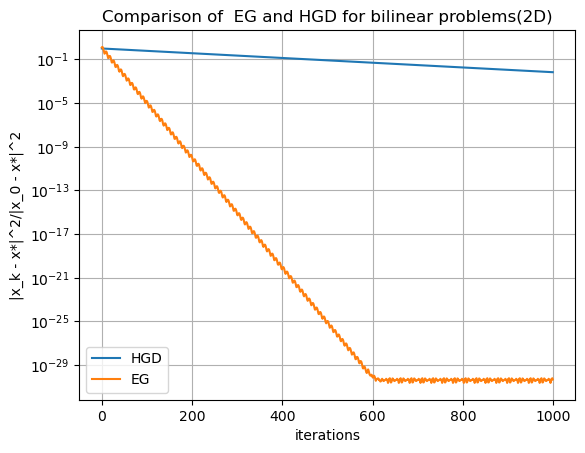

In [364]:
# just show the convergence; the 2-d plot is in next cell
plt.plot(np.arange(len(err1)), err1, label = 'HGD')
plt.plot(np.arange(len(err2)), err2, label = 'EG')
plt.yscale('log')
plt.grid(True)
plt.ylabel("|x_k - x*|^2/|x_0 - x*|^2")
plt.xlabel("iterations")
plt.legend()
plt.title('Comparison of  EG and HGD for bilinear problems(2D)')

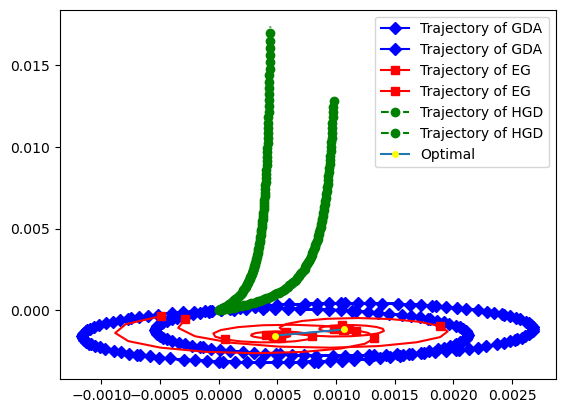

In [358]:
# Hint: use the following code for the plot related to the trajectories. 

markers_on = np.arange(0, 1000, 1000/100).astype(int)
plt.plot(GDA_trajectory_x, GDA_trajectory_y,"-bD", markevery = markers_on, label = "Trajectory of GDA")
plt.plot(EG_trajectory_x, EG_trajectory_y,"-rs", markevery = markers_on, label = "Trajectory of EG")
plt.plot(HGD_trajectory_x, HGD_trajectory_y,"go--", markevery = markers_on, label = "Trajectory of HGD")
plt.plot(x1_star_bi,x2_star_bi, marker="o", markersize=4, markeredgecolor="yellow", markerfacecolor="yellow", label= "Optimal")
plt.legend()

## Summary of findings (1.6)
Yes, the resulting behavior is exactly same what we would expect from theory. Both HGD and EG converges to the optimal while GDA can't since we are solving a bilinear problem. 

The learning rate I used for EG is theoratically guranteed to converge. For HGD, I just randomly pick a learning rate that works. 

### Task 2: Numerical Evaluation of Stochastic Gradient Descent Ascent (SGDA)

For this taks we only focus on the quadratic SC-SC problem. For solving it we use SGDA with single-element uniform sampling. 

$$ x^{k+1} =  x^k- \alpha_k F_i(x^k)$$

In class, we explained and proved the convergebce of SGDA with constant step-size ($\alpha_k= \alpha=\frac{1}{2\ell_\xi}$) and SGDA with switching step-size rule

\begin{equation}
\alpha_k= 
\begin{cases}
\displaystyle \frac{1}{2 \ell_\xi} & \mbox{for}\quad k \leq 4\lceil\mathcal{K} \rceil \\[0.3cm]
\displaystyle \frac{2k+1}{(k+1)^2 \mu} &  \mbox{for}\quad k > 4\lceil\mathcal{K} \rceil.
\end{cases}
\end{equation}

$\textbf{2.1.}$ (10 Points) Please compare the perfornace of SGDA with the above two step-size selections. Does the practical performance verify the theoretical results we presented in the class?

In [695]:
# In here I defined a function which performs stochastic GDA with single-element uniform sampling 
# when you set switching is on, then the SGDA use decreasing step-size 
import random

def stochastic_GDA_min_max_with_error(data, gamma, num_iterations, x1_star, x2_star,switching=False):
    """
    Stochastic Gradient Descent-Ascent (GDA) algorithm for quadratic SC-SC problem,
    handling separate variables x1 and x2, and computing the relative error rate.
    The batch size is set to 1.

    :param data: Synthetic data for the problem (matrices and vectors).
    :param gamma: Step size.
    :param num_iterations: Number of iterations to run the algorithm.
    :param x1_star: Optimal point for x1.
    :param x2_star: Optimal point for x2.
    :return: List of relative errors over the iterations.
    """
    A_matrices, C_matrices, B_matrices, a_vectors, c_vectors = data

    x1 = np.zeros(len(A_matrices[0]))  # Assuming initial point x1 is the origin
    x2 = np.zeros_like(x1)             # Assuming initial point x2 is the origin
    relative_errors = []

    for _ in range(num_iterations):
        # Randomly select a single data index for the current iteration
        i = random.randint(0, len(A_matrices) - 1)

        # Calculate gradients for x1 and x2 using the single selected sample
        grad_x1 = A_matrices[i] @ x1 + B_matrices[i] @ x2 + a_vectors[i]
        grad_x2 = B_matrices[i].T @ x1 - C_matrices[i] @ x2 - c_vectors[i]
        
        # calculated the switching step-size
        
        if switching==True:
            if _ > 38*4: # 38*4 is getting from (l/mu)*4
                new_gamma=(2*_+1)/((_+1)*(_+1)/mu)
                gamma=new_gamma

        # Update steps
        x1 = x1 - gamma * grad_x1
        x2 = x2 + gamma * grad_x2

        # Calculate relative errors
        error_x1 = np.linalg.norm(x1 - x1_star)**2
        error_x2 = np.linalg.norm(x2 - x2_star)**2
        relative_error = (error_x1 / np.linalg.norm(x1_star)**2 + error_x2 / np.linalg.norm(x2_star)**2) / 2
        relative_errors.append(relative_error)

    return relative_errors

In [497]:
# Now, it is critical to compute the constant step-size that has theoratical convergence gurantee. 
# Throgh simple calculation, we know the expected coercity is just max(l_i)
def compute_individual_L(A_matrices, B_matrices, C_matrices):
    """
    Compute the individual Lipschitz constants L_i for each data point in the SC-SC problem.

    :param A_matrices: List of A matrices.
    :param B_matrices: List of B matrices.
    :param C_matrices: List of C matrices.
    :return: List of individual Lipschitz constants L_i.
    """
    L_values = []

    for A, B, C in zip(A_matrices, B_matrices, C_matrices):
        # Form the matrix M for each data point
        M = np.block([[A, B], [B.T, -C]])

        # Compute the individual Lipschitz constant L_i
        L_i = np.sqrt(np.max(np.linalg.eigvalsh(M.T @ M)))
        L_values.append(L_i)

    return L_values

li=np.array(compute_individual_L(A_matrices, B_matrices, C_matrices))
def compute_individual_mu(A_matrices, C_matrices):
    """
    Compute the individual strong monotonicity parameters mu_i for each data point in the SC-SC problem.

    :param A_matrices: List of A matrices.
    :param C_matrices: List of C matrices.
    :return: List of individual strong monotonicity parameters mu_i.
    """
    mu_values = []

    for A, C in zip(A_matrices, C_matrices):
        # Compute the smallest eigenvalues of A and C
        mu1 = np.min(np.linalg.eigvalsh(A))
        mu2 = np.min(np.linalg.eigvalsh(C))

        # Determine the smaller of mu1 and mu2 for each pair of matrices
        mu_i = min(mu1, mu2)
        mu_values.append(mu_i)

    return mu_values
mu_i=np.array(compute_individual_mu(A_matrices, C_matrices))
l_co=np.max(np.square(li)/mu_i)
iteration_changing_step_size=l_co/mu
gama_1=1/(2*l_co)

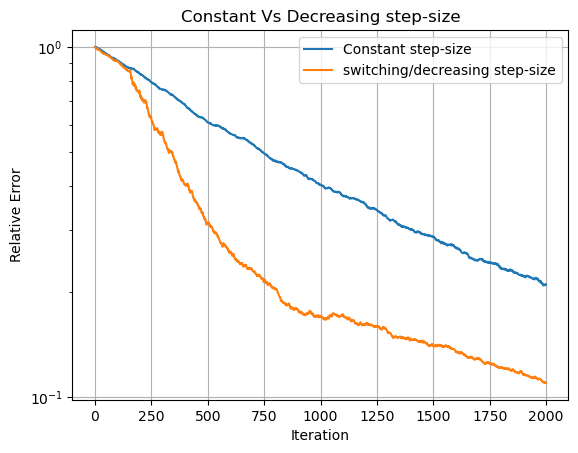

In [696]:
SGDA_constant_err1 = stochastic_GDA_min_max_with_error((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors),gamma_1, 2000,x1_star, x2_star,switching=False)
SGDA_decreasing_err2 = stochastic_GDA_min_max_with_error((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors),gamma_1, 2000,x1_star, x2_star,switching=True)
# Plot the Relative Error
plt.plot(np.arange(len(SGDA_constant_err1)), SGDA_constant_err1, label = 'Constant step-size')
plt.plot(np.arange(len(SGDA_decreasing_err2)), SGDA_decreasing_err2, label = 'switching/decreasing step-size')

plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Iteration")
plt.title('Constant Vs Decreasing step-size')
plt.legend()

## Summary of findings (2.1)

From the SGDA with the constant step-size, we can find that it never converge to the actual solution. Instead, It converges to the neighborhood of the optimal. 

Also, we can tell from the graph that decreasing step-size performs really well and it converges to a vanishing small neignborhood of the actual solution. However, it takes a lot of steps for the algorithm to converge. 

What we can see from the chart largely concurs with what we learned from the class. 

$\textbf{2.2.}$ (10 Points) In class we also presented and analyzed a variance reduced method for solving SC-SC problems. That is, L-SVRGDA. please design the L-SVRGDA method as presented in the class and compare the SGDA (constant step-size) with L-SVRGDA and explain your output. 

In [511]:
def L_SVRGDA(data, gamma, num_iterations, x1_star, x2_star,p):
    """
    Stochastic Gradient Descent-Ascent (GDA) algorithm for quadratic SC-SC problem,
    handling separate variables x1 and x2, and computing the relative error rate.
    The batch size is set to 1.

    :param data: Synthetic data for the problem (matrices and vectors).
    :param gamma: Step size.
    :param num_iterations: Number of iterations to run the algorithm.
    :param x1_star: Optimal point for x1.
    :param x2_star: Optimal point for x2.
    :return: List of relative errors over the iterations.
    """
    A_matrices, C_matrices, B_matrices, a_vectors, c_vectors = data

    x1 = np.zeros(len(A_matrices[0]))  # Assuming initial point x1 is the origin
    x2 = np.zeros_like(x1)             # Assuming initial point x2 is the origin
    relative_errors = []
    
    # define w1 and w2 first
    
    w1=x1
    w2=x2
    
    for _ in range(num_iterations):
        # Randomly select a single data index for the current iteration
        i = random.randint(0, len(A_matrices) - 1)

        # Calculate gradients for x1 and x2 using the single selected sample
        grad_x1 = A_matrices[i] @ x1 + B_matrices[i] @ x2 + a_vectors[i]
        grad_x2 = B_matrices[i].T @ x1 - C_matrices[i] @ x2 - c_vectors[i]
        
        # calculates gradients for w1 and w2 using the single selected sample 
        f_w1=A_matrices[i] @ w1 + B_matrices[i] @ w2 + a_vectors[i]
        f_w2=B_matrices[i].T @ w1 - C_matrices[i] @ w2 - c_vectors[i]
        
        # compute the full gradient for w1 and w2      
        grad_x1_f= lambda x1, x2: np.mean([A_matrices[n] @ x1 + B_matrices[n] @ x2 + a_vectors[n] for n in range(len(A_matrices))], axis=0)
        grad_x2_f= lambda x1, x2: np.mean([B_matrices[n].T @ x1 - C_matrices[n] @ x2 - c_vectors[n] for n in range(len(C_matrices))], axis=0)
        
        full_grad_w1=grad_x1_f(w1,w2)
        full_grad_w2=grad_x2_f(w1,w2)
        
        # get the g
        
        g1=grad_x1-f_w1+full_grad_w1
        g2=grad_x2-f_w2+full_grad_w2
        
        # update w 
        random_number = random.random()
        if random_number<=p:
            w1=x1
            w2=x2
            
        # Update steps
        x1 = x1 - gamma * g1
        x2 = x2 + gamma * g2

        # Calculate relative errors
        error_x1 = np.linalg.norm(x1 - x1_star)**2
        error_x2 = np.linalg.norm(x2 - x2_star)**2
        relative_error = (error_x1 / np.linalg.norm(x1_star)**2 + error_x2 / np.linalg.norm(x2_star)**2) / 2
        relative_errors.append(relative_error)

    return relative_errors

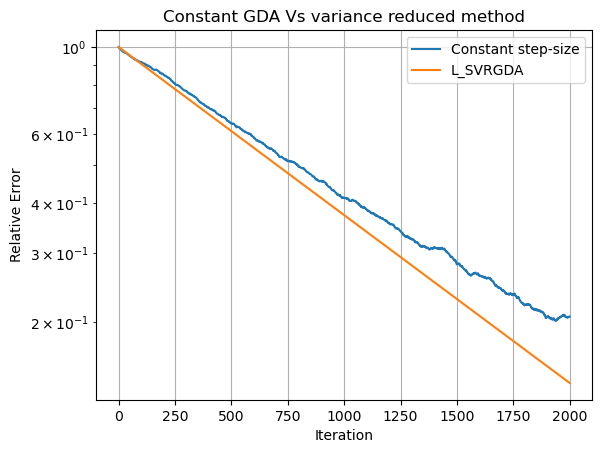

In [514]:
LSVRG_error=L_SVRGDA((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors),gamma_1, 2000,x1_star, x2_star,1/100)

SGDA_constant_err1 = stochastic_GDA_min_max_with_error((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors),gamma_1, 2000,x1_star, x2_star,switching=False)

# Plot the Relative Error
plt.plot(np.arange(len(SGDA_constant_err1)), SGDA_constant_err1, label = 'Constant step-size')
plt.plot(np.arange(len(LSVRG_error)), LSVRG_error, label = 'L_SVRGDA')

plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Iteration")
plt.title('Constant GDA Vs variance reduced method')
plt.legend()

# Summary of finings (2.2)
As one might expect, the LSVRGDA converges faster than SGDA does under the extact same constant setp-size. In addition, the LSVRGDA achieves higher accuracy.  So In practice, we should prefer variance reduced method more often. 

### Task 3: Numerical Evaluation of Stochastic exragradient method (SEG)
In class we present same-sample SEG method and explain how it behaves in practical scenarios
\begin{equation}
	x^{k+1} = x^k - \gamma_{2,\xi^k} F_{\xi^k}\left(x^k - \gamma_{1,\xi^k} F_{\xi^k}(x^k)\right), \tag{S-SEG} \label{eq:S_SEG}
\end{equation}

$\textbf{3.1.}$ (10 Points) Please design S_SEG (single-element uniform sampling)

In [529]:
def SEG(data, num_iterations, x1_star, x2_star,gamma1,gamma2):
    """
    Extragradient (EG) method for quadratic SC-SC and bilinear min-max problems,
    handling separate variables x1 and x2, and computing the relative error rate.

    :param data: Synthetic data for the problem (matrices and vectors).
    :param problem_type: Type of the problem ('quadratic_SCSC' or 'bilinear').
    :param gamma: Step size.
    :param num_iterations: Number of iterations to run the algorithm.
    :param x1_star: Optimal point for x1.
    :param x2_star: Optimal point for x2.
    :return: List of relative errors over the iterations.
    """

    x1 = np.zeros(len(data[0][0]))  # Assuming initial point x1 is the origin
    x2 = np.zeros_like(x1)         # Assuming initial point x2 is the origin
    relative_errors = []

    for _ in range(num_iterations):
        
        # Randomly select a single data index for the current iteration
        i = random.randint(0, len(A_matrices) - 1)

        # Calculate gradients for x1 and x2 using the single selected sample
        grad_x1 = A_matrices[i] @ x1 + B_matrices[i] @ x2 + a_vectors[i]
        grad_x2 = B_matrices[i].T @ x1 - C_matrices[i] @ x2 - c_vectors[i]
        
        # Extrapolation step
        tilde_x1 = x1 - gamma1 * grad_x1
        tilde_x2 = x2 + gamma1 * grad_x2
        
        # new grad
        grad_x1_new = A_matrices[i] @ tilde_x1 + B_matrices[i] @ tilde_x2  + a_vectors[i]
        grad_x2_new = B_matrices[i].T @ tilde_x1 - C_matrices[i] @ tilde_x2  - c_vectors[i]

        # Actual update step
        x1 = x1 - gamma2 * grad_x1_new
        x2 = x2 + gamma2 * grad_x2_new

        error_x1 = np.linalg.norm(x1 - x1_star)**2
        error_x2 = np.linalg.norm(x2 - x2_star)**2
        
        relative_error_1 = (error_x1 ) / (np.linalg.norm(x1_star)**2)
        relative_error_2=(error_x2)/(np.linalg.norm(x2_star)**2)
        relative_error=(relative_error_1+relative_error_2)/2
        relative_errors.append(relative_error)
    return relative_errors 

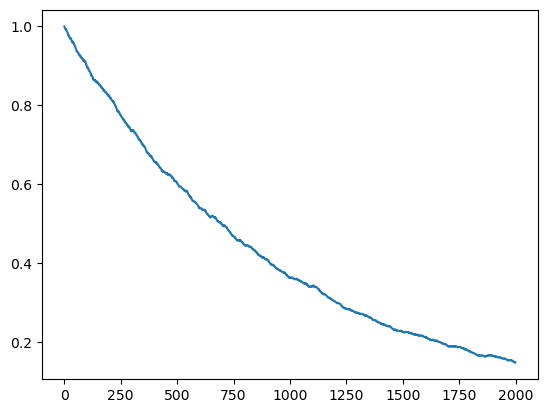

In [530]:
error_SEG=SEG((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors), 2000,x1_star, x2_star,0.001,0.001)
plt.plot(error_SEG)

You can see if we use some random, small step sizes, we got a descent result. 

$\textbf{3.2.}$ (10 Points) Compare S-SEG with the following choices of step-sizes for solving the quadratic SC-SC.  

1. S-SEG with $\gamma_1=1/6L$ and $\gamma_2=\gamma_1/4$
2. S-SEG with $\gamma_1=\gamma_2=1/2L$

Explain your findings.

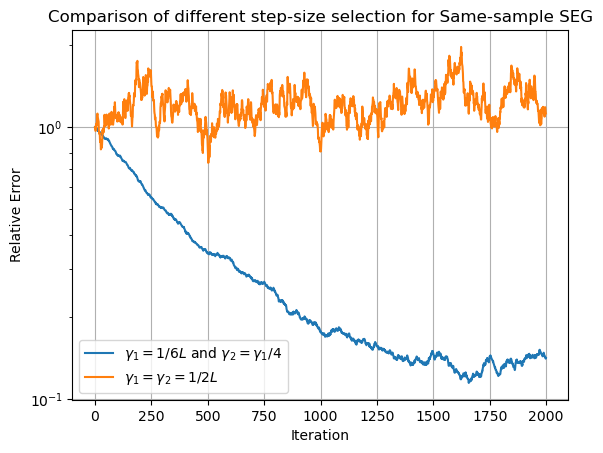

In [550]:
SEG_err1 = SEG((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors), 2000,x1_star, x2_star,(1/(l_co*6)),(1/(l_co*6*4)))
SEG_err2 = SEG((A_matrices, C_matrices, B_matrices, a_vectors, c_vectors), 2000,x1_star, x2_star,(1/(l_co*2)),(1/(l_co*2)))
# Plot the Relative Error
plt.plot(np.arange(len(SEG_err1)), SEG_err1, label = '$\gamma_1=1/6L$ and $\gamma_2=\gamma_1/4$')
plt.plot(np.arange(len(SEG_err2)), SEG_err2, label = '$\gamma_1=\gamma_2=1/2L$')

plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Iteration")
plt.title('Comparison of different step-size selection for Same-sample SEG')
plt.legend()

## Summary of findings (3.2)
Unforetunately, the algorithm won't converge under ubder the setting 2 (orange line). But under setting one, we coudld have a very descent convergence to the optimal.

I suspect that it is because under setting (II), learning rate is not small enough to gurantee convergence. 

### Task 4: Numerical Evaluation of Stochastic Hamiltonian Gradient Method

In class we explain how instead of solving the original min-max optimization problem one can design and solve an equivalent (same solution set) optimization problem by designing an appropriate Hamiltonian Function. We show that a good choice for the problems under study is the following choice for the Hamiltonian function:

\begin{equation}
\label{HamiltonianProblem}
 \min_x \quad H(x)= \frac{1}{2} \|\xi(x)\|^2,
\end{equation}
where $\xi(x)=\begin{pmatrix}\nabla_{x_1} f (x_1,x_2) \\ -\nabla_{x_2} f (x_1,x_2) \end{pmatrix}$.

We explained that in the stochastic (finite-sum structure) regime this become equivalent to: 

\begin{eqnarray}
\label{StochHamiltonianFunction}
H(x)=\frac{1}{n^2} \sum_{i,j=1}^n H_{i,j}(x) \quad\textrm{where }\quad H_{i,j}(x)=\frac{1}{2} \langle  \xi_i(x),  \xi_j(x)\rangle\end{eqnarray}
where $\xi_i(x)=\begin{pmatrix}\nabla_{x_1} f_i (x_1,x_2) \\ -\nabla_{x_2} f_i (x_1,x_2) \end{pmatrix}$.

For the stochastic bilinear problem we proved that the Hamiltonian function a quadratic quasi-strongly convex and smooth function. This means that for minimizing the stochastic Hamiltonian function one can run any optimization method that solves quasi strongly convex and smooth problems. 

In this task we will use SGD and L-SVRG in combination with the Hamiltonian viewpoint and show their performance. 

The SHGD method behaves as follows in each iteration:
- Generate fresh samples $i \sim {\cal D}$ and  $j \sim {\cal D}$ and evaluate $\nabla H_{i,j}(x^k)$.
- Set step-size $\gamma_k$ (constant, decreasing)
- Set $$x^{k+1}=x^k -\gamma_k \nabla H_{i,j}(x^k)$$

$\textbf{4.1.}$ (10 Points) Design the SHGD and compare the perfornace of SHGD with the above constant and decreasing step-size selections we described in class. Does the practical performance verify the theoretical results we presented in the class?

In [688]:
def SHGD_bilinear(data, gamma, num_iterations, x1_star, x2_star,switching=False ):
    """
    Hamiltonian Gradient Descent (HGD) algorithm for bilinear min-max problems using the Hessian matrix.

    :param data: Synthetic data for the problem (matrices A, b, c).
    :param gamma: Step size.
    :param num_iterations: Number of iterations to run the algorithm.
    :param x1_star: Optimal point for x1.
    :param x2_star: Optimal point for x2.
    :return: List of relative errors over the iterations.
    """
    A_matrices, b_vectors, c_vectors = data

    x1 = np.zeros(len(A_matrices[0]))  # Initial point x1
    x2 = np.zeros_like(x1)             # Initial point x2
    relative_errors = []

    for _ in range(num_iterations):
        
        # Randomly select a single data index for the current iteration
        i = random.randint(0, len(A_matrices) - 1)
        j = random.randint(0, len(A_matrices) - 1)
        
        # compute the gradient first of i 
        grad_x1_i = A_matrices[i] @ x2 + b_vectors[i]
        grad_x2_i= -(A_matrices[i].T @ x1 + c_vectors[i])
        
        # compute the gradient first of j 
        grad_x1_j= A_matrices[j] @ x2 + b_vectors[j]
        grad_x2_j= -(A_matrices[j].T @ x1 + c_vectors[j])
        
        # compute each entry in our Hessian (matrix J_i)
        term_1_i=np.zeros_like(A_matrices[0]) #row1 
        term_2_i=A_matrices[i] #row1
        
        term_3_i=A_matrices[i].T
        term_4_i=np.zeros_like(A_matrices[0])
        
        # compute each entry in our Hessian (matrix J_j)
        term_1_j=np.zeros_like(A_matrices[0]) #row1 
        term_2_j=A_matrices[j] #row1
        
        term_3_j=A_matrices[j].T
        term_4_j=np.zeros_like(A_matrices[0])
        
        # compute the local update
        x_1_p1=term_1_i@grad_x1_j-term_3_i@grad_x2_j
        x_2_p1=term_2_i@grad_x1_j-term_4_i@grad_x2_j
        
        x_1_p2=term_1_j@grad_x1_i-term_3_j@grad_x2_i
        x_2_p2=term_2_j@grad_x1_i-term_4_j@grad_x2_i
        
        x_1_update=(x_1_p1+x_1_p2)/2
        x_2_update=(x_2_p1+x_2_p2)/2
        
        if switching==True:
            if _ > 40000: # 38 is getting from l/mu 
                new_gamma=(2*_+1)/((_+1)**2*mu_HGD)
                gamma=new_gamma
        
        x1=x1-gamma*x_1_update
        x2=x2-gamma*x_2_update


        # Calculate the relative error
        error_x1 = np.linalg.norm(x1 - x1_star)**2
        error_x2 = np.linalg.norm(x2 - x2_star)**2
        relative_error_1 = error_x1 / np.linalg.norm(x1_star)**2
        relative_error_2 = error_x2 / np.linalg.norm(x2_star)**2
        relative_error = (relative_error_1 + relative_error_2) / 2
        relative_errors.append(relative_error)

    return relative_errors

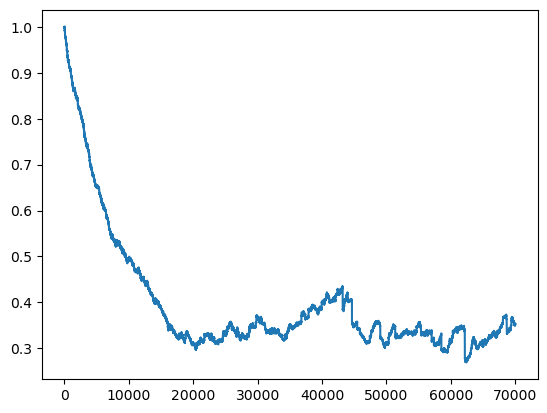

In [704]:
# some simple demo
error_HGD=SHGD_bilinear((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors), 0.5, 70000,x1_star_bi,x2_star_bi,switching=False)
plt.plot(error_HGD)

In [663]:
# Now we need to know mu 
A=np.mean(corrected_A_matrices_bilinear,axis=0)
# Compute the singular values using SVD
U, s, Vh = np.linalg.svd(A)
# Filter out zero singular values if any, and then take the minimum
# This will give the smallest non-zero singular value
smallest_nonzero_singular_value = np.min(s[np.nonzero(s)])
largest_nonzero_singular_value = np.max(s[np.nonzero(s)])
L_HGD=largest_nonzero_singular_value**2
mu_HGD=smallest_nonzero_singular_value**2
print(L_HGD)
print(mu_HGD)

0.0001
0.0001


In [674]:
# learning rate (constant)
1/(2*(L_bi**2/mu_HGD))

0.5

In [677]:
# point where we decrease the learning rate 
L_bi**2/mu_HGD/mu_HGD

10000.0

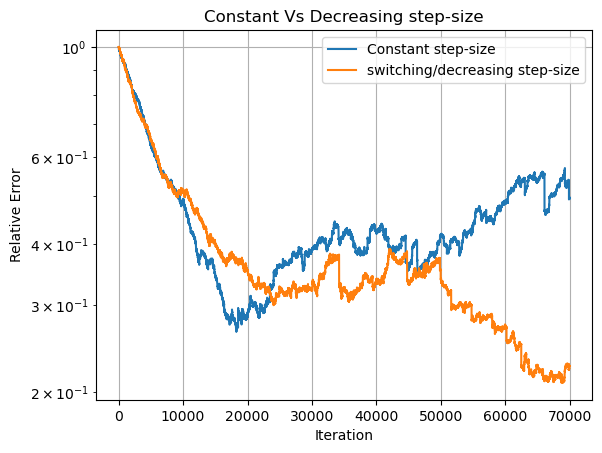

In [703]:
SHGD_constant_err1 = SHGD_bilinear((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors), 0.5, 70000,x1_star_bi,x2_star_bi,switching=False)
SHGD_decreasing_err2 =SHGD_bilinear((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors), 0.5, 70000,x1_star_bi,x2_star_bi,switching=True)
# Plot the Relative Error
plt.plot(np.arange(len(SHGD_constant_err1)), SHGD_constant_err1, label = 'Constant step-size')
plt.plot(np.arange(len(SHGD_decreasing_err2)), SHGD_decreasing_err2, label = 'switching/decreasing step-size')

plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Iteration")
plt.title('Constant Vs Decreasing step-size')
plt.legend()

## Summary for 4.1
It is indeed that our SHGD with switched/decreased step-size is closer to the optimal solution. It indeed verify the theory presented in the class. 

$\textbf{4.2.}$ (10 points) In class we provide and prove the convergence of Loopless Stochastic Variance Reduced Hamiltonian Gradient method (L-SVRHG). Please design the L-SVRHG and compare its perfornace to SHGD with constant step-size.  Does the practical performance verify the theoretical results we presented in the class?

In [722]:
def LSVRHG(data, gamma, num_iterations, x1_star, x2_star):
    """
    Hamiltonian Gradient Descent (HGD) algorithm for bilinear min-max problems using the Hessian matrix.

    :param data: Synthetic data for the problem (matrices A, b, c).
    :param gamma: Step size.
    :param num_iterations: Number of iterations to run the algorithm.
    :param x1_star: Optimal point for x1.
    :param x2_star: Optimal point for x2.
    :return: List of relative errors over the iterations.
    """
    A_matrices, b_vectors, c_vectors = data

    x1 = np.zeros(len(A_matrices[0]))  # Initial point x1
    x2 = np.zeros_like(x1)             # Initial point x2
    relative_errors = []

    w1=x1
    w2=x2

    for _ in range(num_iterations):
        # Randomly select a single data index for the current iteration
        i = random.randint(0, len(A_matrices) - 1)
        j = random.randint(0, len(A_matrices) - 1)

        # compute the gradient first of i 
        grad_x1_i = A_matrices[i] @ x2 + b_vectors[i]
        grad_x2_i= -(A_matrices[i].T @ x1 + c_vectors[i])

        # compute the gradient first of j 
        grad_x1_j= A_matrices[j] @ x2 + b_vectors[j]
        grad_x2_j= -(A_matrices[j].T @ x1 + c_vectors[j])

        # compute each entry in our Hessian (matrix J_i)
        term_1_i=np.zeros_like(A_matrices[0]) #row1 
        term_2_i=A_matrices[i] #row1

        term_3_i=A_matrices[i].T
        term_4_i=np.zeros_like(A_matrices[0])

        # compute each entry in our Hessian (matrix J_j)
        term_1_j=np.zeros_like(A_matrices[0]) #row1 
        term_2_j=A_matrices[j] #row1

        term_3_j=A_matrices[j].T
        term_4_j=np.zeros_like(A_matrices[0])

        # compute the local update
        x_1_p1=term_1_i@grad_x1_j-term_3_i@grad_x2_j
        x_2_p1=term_2_i@grad_x1_j-term_4_i@grad_x2_j

        x_1_p2=term_1_j@grad_x1_i-term_3_j@grad_x2_i
        x_2_p2=term_2_j@grad_x1_i-term_4_j@grad_x2_i

        # this is the stochatic H for x_ij
        x_1_update=(x_1_p1+x_1_p2)/2
        x_2_update=(x_2_p1+x_2_p2)/2

        ##### Evaluate for wk 
        # compute the gradient first of i 
        grad_w1_i = A_matrices[i] @ w2 + b_vectors[i]
        grad_w2_i= -(A_matrices[i].T @ w1 + c_vectors[i])

        # compute the gradient first of j 
        grad_w1_j= A_matrices[j] @ w2 + b_vectors[j]
        grad_w2_j= -(A_matrices[j].T @ w1 + c_vectors[j])

        # compute each entry in our Hessian (matrix J_i)
        term_1_i=np.zeros_like(A_matrices[0]) #row1 
        term_2_i=A_matrices[i] #row1

        term_3_i=A_matrices[i].T
        term_4_i=np.zeros_like(A_matrices[0])

        # compute each entry in our Hessian (matrix J_j)
        term_1_j=np.zeros_like(A_matrices[0]) #row1 
        term_2_j=A_matrices[j] #row1

        term_3_j=A_matrices[j].T
        term_4_j=np.zeros_like(A_matrices[0])

        # compute the local update
        w_1_p1=term_1_i@grad_w1_j-term_3_i@grad_w2_j
        w_2_p1=term_2_i@grad_w1_j-term_4_i@grad_w2_j

        w_1_p2=term_1_j@grad_w1_i-term_3_j@grad_w2_i
        w_2_p2=term_2_j@grad_w1_i-term_4_j@grad_w2_i

        # this is the stochatic H for w_ij
        w_1_update=(w_1_p1+w_1_p2)/2
        w_2_update=(w_2_p1+w_2_p2)/2

        ##### Evaluate H under the full gradient 
        # compute the gradient first
        grad_w1 = np.mean([A @ w2 + b for A, b in zip(A_matrices, b_vectors)], axis=0)
        grad_w2 = -np.mean([A.T @ w1 + c for A, c in zip(A_matrices, c_vectors)], axis=0)

        # compute each entry in our Hessian (matrix J)
        term_1=np.zeros_like(A_matrices[0]) #row1 
        term_2=np.mean(A_matrices,axis=0) #row1

        term_3=np.mean(A_matrices,axis=0).T
        term_4=np.zeros_like(A_matrices[0])

        w_1_update_full=term_1@grad_w1-term_3@grad_w2
        w_2_update_full=term_2@grad_w1-term_4@grad_w2

        ### compute the Gk 

        total_update_x1=x_1_update- w_1_update+w_1_update_full
        total_update_x2=x_2_update- w_2_update+w_2_update_full

        x1=x1-gamma*total_update_x1
        x2=x2-gamma*total_update_x2


        # Calculate the relative error
        error_x1 = np.linalg.norm(x1 - x1_star)**2
        error_x2 = np.linalg.norm(x2 - x2_star)**2
        relative_error_1 = error_x1 / np.linalg.norm(x1_star)**2
        relative_error_2 = error_x2 / np.linalg.norm(x2_star)**2
        relative_error = (relative_error_1 + relative_error_2) / 2
        relative_errors.append(relative_error)

    return relative_errors 

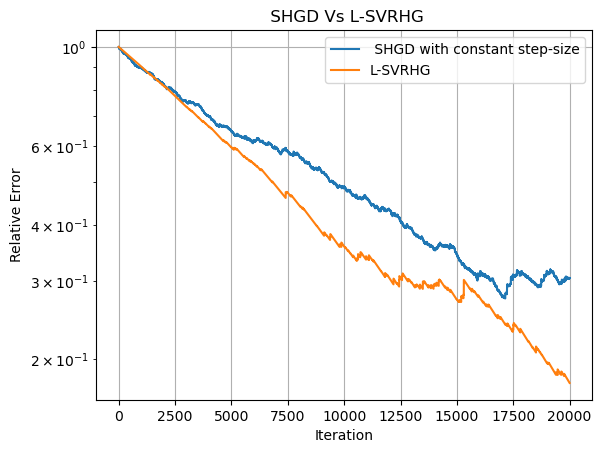

In [725]:
SHGD_constant_err1 = SHGD_bilinear((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors), 0.5, 20000,x1_star_bi,x2_star_bi,switching=False)
LSVRHG_err2 = LSVRHG((corrected_A_matrices_bilinear, corrected_b_vectors, corrected_c_vectors), 0.5, 20000,x1_star_bi,x2_star_bi)
# Plot the Relative Error
plt.plot(np.arange(len(SHGD_constant_err1)), SHGD_constant_err1, label = ' SHGD with constant step-size')
plt.plot(np.arange(len(LSVRHG_err2)), LSVRHG_err2, label = 'L-SVRHG')

plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Iteration")
plt.title(' SHGD Vs L-SVRHG')
plt.legend()

## summary for 4.2 
As expected, we can see that the LSVRHG method converges faster than SHGD does (under the same learning rate). It also achieves better accuracy than SHGD does, which meets our expectation backen by the theroy presented in the class. 